In [1]:
# Go to base directory
%cd ..

/home/tourloid/Desktop/PhD/Code/SPVD


### Imports

In [2]:
#export
import torch 
import torch.nn as nn
import torchsparse
import torchsparse.nn as spnn

from utils import model_num_params
from models.spvd import PointBlock, StemBlock, SPVDownStage, SPVUpStage, lin, timestep_embedding
from models.sparse_utils import initial_voxelize, voxel_to_point, point_to_voxel, PointTensor

### Conditional SPVDUnet

In [3]:
#export
class CondSPVUnet(nn.Module):
    """
        Definition of a DownBlock:
        
        Convolutions : | 32 -> 64 | 64 -> 128 | 128 -> 192 |
        Add down conv: |   True   |   True    |    True    |  
        Attn chans:    |   None   |   None    |    None    |
        Kernel size:   |     3    |     3     |      3     |  (only to skip conv blocks during upsampling --> reduce parameters)
        Name:        How to call this layer

    """
    def __init__(self, point_channels=3, voxel_size=0.1, n_classes=55,
                 down_blocks = [[(64, 128, 192, 256, 384, 384), (True, True, True, True, False), (None, None, None, 8, 8)]], # only one point skip connection during downsampling
                 up_blocks   = [[(384, 384, 256), (True, True), (8, 8), (3, 3)], 
                                [(256, 192, 128, 64), (True, True, False), (None, None, None), (3, 3, 3)]],
                 num_layers=1, pres=1e-5):
        super().__init__()
        self.pres=pres
        self.voxel_size=voxel_size
        self.msg = f'Point Resolution: {self.pres} | Voxel Resolution: {self.voxel_size}\n'
        
        # time embedding
        self.n_temb = nf = down_blocks[0][0][0]
        n_emb = nf * 4
        self.emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d),
                                     lin(n_emb, n_emb))
        self.msg += f'Time Embedding size - before mlp: {self.n_temb} , -after mlp: {n_emb} \n'

        # conditional embedding
        self.cond_emb = nn.Embedding(n_classes, n_emb)
        self.msg += f'Conditional Embedding - classes: {n_classes}, - size: {n_emb} - Params: {model_num_params(self.cond_emb)}\n' 
                
        self.stem_conv = StemBlock(point_channels, down_blocks[0][0][0])
        self.msg += self.stem_conv.msg

        add_down_vals = []
        self.down_stages = nn.ModuleList()
        for i, block_config in enumerate(down_blocks):
            nfs, add_down, attn_chans = block_config
            add_down_vals.extend(add_down)
            name = f'Down Stage {i}'
            self.down_stages.append(SPVDownStage(n_emb, nfs=nfs, add_down=add_down, attn_chans=attn_chans, name=name, num_layers=num_layers))
            self.msg += self.down_stages[-1].msg
        
        self.mid_stages = nn.Identity()

        self.up_stages = nn.ModuleList()
        for i, block_config in enumerate(up_blocks):
            nfs, add_up, attn_chans, ks = block_config
            name = f'Up Stage {i}'
            self.up_stages.append(SPVUpStage(n_emb, nfs=nfs, add_up=add_up, attn_chans=attn_chans, ks=ks, num_layers=num_layers+1, name=name))
            self.msg += self.up_stages[-1].msg

        self.out_conv = nn.Sequential(
            nn.BatchNorm1d(up_blocks[-1][0][-1]),
            nn.SiLU(), 
            nn.Linear(up_blocks[-1][0][-1], point_channels, bias=False),
        )

        self.msg += '** Noise Predictor ** \n'
        self.msg += f' LinearLayer({up_blocks[-1][0][-1]}, {point_channels})'
        self.msg += f' - Params: {model_num_params(self.out_conv)} \n'
        
        self.msg += f'Total Parameters: {model_num_params(self)/1e6:0.1f}M'

    def summary(self):
        print(self.msg)


    def forward(self, inp):

        # Input Processing
        x, t, c = inp
        z = PointTensor(x.F, x.C.float()) # CHECK
        t = timestep_embedding(t, self.n_temb)
        cemb = self.cond_emb(c)
        emb = self.emb_mlp(t) + cemb 

        # Initial Voxelization
        x0 = initial_voxelize(z, self.pres, self.voxel_size)

        # Stem convolution
        x, z = self.stem_conv(x0, z)

        saved = [x]

        for d in self.down_stages:
            x, z = d(x, z, emb)
            saved += [p for p in d.saved]

        #x = self.mid_stages(x, emb)

        for u in self.up_stages:
            x, z = u(x, z, emb, saved)
        
        return self.out_conv(z.F)

## Training

### DDPM Callback

In [4]:
from pclab.learner import *
from utils.callbacks import *
from pclab.learner import Callback
from functools import partial

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
class CondDDPMCB(Callback):
    
    def before_batch(self, learn): 
        pts = learn.batch['input']
        t = torch.tensor(learn.batch['t'])
        noise = learn.batch['noise']
        c = torch.tensor(learn.batch['sid'])
        inp = (pts, t, c)
        learn.batch = (inp, noise.F)

### Datasets and Dataloaders

In [6]:
from datasets.shapenet_pointflow_sparse_cond import get_dataloaders
from pclab.utils import DataLoaders

In [7]:
path = '/home/tourloid/Desktop/PhD/Data/ShapeNetCore.v2.PC15k/'
tr_dl, te_dl = get_dataloaders(path, ['all'])
dls = DataLoaders(tr_dl, te_dl)

(1, 1, 1)
Total number of data:35708
Min number of points: (train)2048 (test)2048
(1, 1, 1)
Total number of data:5158
Min number of points: (train)2048 (test)2048


In [8]:
batch = next(iter(tr_dl))
batch.keys()

dict_keys(['input', 't', 'noise', 'sid'])

### LRFinder

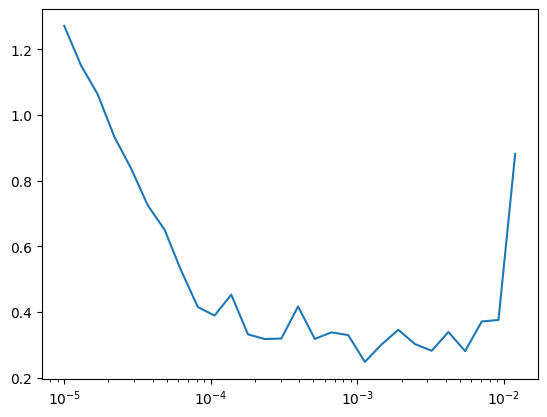

In [9]:
ddpm_cb = CondDDPMCB()
model = CondSPVUnet()
learn = TrainLearner(model, dls, nn.MSELoss(), cbs=[ddpm_cb, DeviceCBSparse(), GradientClipCB()], opt_func=torch.optim.Adam)
learn.lr_find(max_mult=3)

### Training

In [12]:
lr = 0.0001 
epochs = 500

model = CondSPVUnet()

# scheduler
total_steps = epochs * len(dls.train)
sched = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, total_steps = total_steps)

# Callbacks
ddpm_cb = CondDDPMCB()
checkpoint_cb = CheckpointCB(100, 'conditional_model_large', run_params={'msg':model.msg})
cbs = [ddpm_cb, DeviceCBSparse(), ProgressCB(plot=True), LossCB(), BatchSchedCB(sched), GradientClipCB(), checkpoint_cb]

learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(epochs)

KeyboardInterrupt: 